## Word2vec

Word2vec models can be easily trained from freely available corpora on the Web. The training is straightforward when using libraries such as Gensim or the [original Google's implementation](https://github.com/tmikolov/word2vec) but may require a lot of time and computing resources. Luckily, many pre-trained models for different languages are available. The [NLPL word embeddings repository](http://vectors.nlpl.eu/repository/) contains models for different languages <cite data-cite="NLPLrepository"></cite>. We will use the English model built on the English CoNLL17 corpus using the skipgram method, which has 4.027.169 words in the vocabulary, and 100 dimensions.

The following libraries are required to run this notebook:

- gensim==3.8.3
- scikit-learn==0.23.2
- matplotlib==3.3.2

Gensim uses the `KeyedVectors` structure which captures similarities of the results for methods such as Word2vec and FastText because the trained vectors have the same structure regardless of the training method. Using the `KeyedVectors` class we will load models trained with the original Google's word2vec implementation.

First of all, some inital configuration is required. We will use inline plotting of images, which will be in the vector format, and we will not display future warnings.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Now we need to download the model and unpack the archive.

In [2]:
from urllib.request import urlopen
# download
data = urlopen('http://vectors.nlpl.eu/repository/20/40.zip')
with open('data/40.zip', "wb") as fp:
    fp.write(data.read())
# unzip data
import zipfile
with zipfile.ZipFile('data/40.zip') as zip:
    zip.extractall('data')

The model can now be loaded into an `KeyedVectors` instance.

In [3]:
import gensim
w2v = gensim.models.keyedvectors.KeyedVectors.load_word2vec_format('data/model.bin', binary=True)

With the model loaded we can get the vectors for any word in the vocabulary. However, out-of-vocabulary words are not handled automatically and the second example below demonstrates the exception returned when such a word is encountered.

In [4]:
import traceback
import numpy as np
np.set_printoptions(precision=3, suppress=True)
print(w2v.get_vector('dog'))
try:
    print(w2v.get_vector('<html>'))
except KeyError as e:
    print(e)
    # use traceback.print_exc() for a detailed output

[ 0.022 -0.286 -0.204 -0.601  0.419 -0.295  0.122 -0.459  0.28   0.485
 -0.32   0.187 -0.246 -0.051 -0.308  0.499  0.365 -0.085  0.28   0.262
  0.086  0.003  0.214 -0.808  0.074  0.125  0.072 -0.221  0.204  0.541
 -0.15   0.548  0.287  0.553 -0.663  0.276  0.064 -0.17  -0.164 -0.077
 -0.506  0.321 -0.077 -0.138  0.226  0.532  0.79   0.084  0.001 -0.204
  0.028  0.174  0.059 -0.231 -0.009 -0.152 -0.14   0.078 -0.477 -0.419
 -0.604 -0.002 -0.339 -0.314 -0.403  0.317  0.249 -0.234  0.28  -0.023
  0.155 -0.408  0.287 -0.034  0.28   0.137  0.43   0.32   0.129  0.017
  0.169  0.013  0.174 -0.233 -0.145 -0.001 -0.112  0.096  0.197  0.023
  0.051  0.137 -0.439 -0.281  0.298 -0.011 -0.542  0.551 -0.238  0.084]
"word '<html>' not in vocabulary"


Gensim offers several useful functions for exploiting the most interesting features of word embeddings. Let's demonstrate some of the word similarity tasks:

In [5]:
w2v.doesnt_match(['cat', 'dog', 'lion', 'snake', 'table'])

'table'

In [6]:
w2v.similar_by_word('dog', topn=5)

[('cat', 0.8616693019866943),
 ('dogs', 0.8479607105255127),
 ('eskie', 0.8324236869812012),
 ('dachsund', 0.8204894065856934),
 ('doggie', 0.8190792798995972)]

The following snippet repeats the famous computation $\text{king}-\text{man}+\text{woman}=\text{queen}$ using Gensim's helper functions. We get the expected result as the highest ranked answer but other less relevant answers are also ranked high:

In [7]:
w2v.similar_by_vector(w2v.get_vector('king') - w2v.get_vector('man') + w2v.get_vector('woman'), topn=5)

[('queen', 0.8596236705780029),
 ('king', 0.8447158336639404),
 ('debsirindra', 0.7552260756492615),
 ('empress', 0.7545188665390015),
 ('supayalat', 0.748792290687561)]

Finally, we will use word2vec word vectors to compute document vectors by simply suming individual word vectors and multiplying each word vector with the corresponding _idf_ value. Such approach is fast and known to work well for word embeddings ([see the work of Zhao, Lan, and Tian](https://www.aclweb.org/anthology/S15-2021.pdf)). We will work with a tiny corpus of 9 titles of scientific papers. First, we need some very basic preprocessing which includes transformation to lowercase, tokenization based on white space characters, and filtering out any tokens that are not in our word2vec model vocabulary:

In [8]:
raw_docs = [
'New Insights Towards Developing Recommender Systems',
'3D Convolutional Neural Networks for Dynamic Sign Language Recognition',
'A DDoS Detection Method for Socially Aware Networking Based on Forecasting Fusion Feature Sequence',
'An image J plugin for the high throughput image analysis of in vitro scratch wound healing assays',
'Interactions between functionalised silica nanoparticles and Pseudomonas fluorescens biofilm matrix',
'A multi-parametric screening platform for photosynthetic trait characterization of microalgae and cyanobacteria under inorganic carbon limitation',
'How schools can reopen safely during the pandemic',
'Carbon dioxide loss from tropical soils increases on warming',
'Horse eyeballs and bone hammers surprising lives of the Neanderthals']
docs = [x.lower().split() for x in raw_docs]
docs = [[token for token in token_list if token in w2v.vocab] for token_list in docs]

We create a dictionary and compute smoothed _idf_ using formula $\text{idf} = \log(\frac{N}{n_t+1})$ (smoothing is recommended to avoid division by zero). Although _idf_ vector weighting will not have much effect in our case with only 9 documents, this is recommended in a general case.

In [9]:
import numpy as np
dic = gensim.corpora.Dictionary(docs)
N = len(docs)
idfs = {}
for token in dic.token2id:
    idfs[token] = np.log2(N / (dic.dfs[dic.token2id[token]]+1))

We now compute document vectors by summing word vectors and weighting them using _idf_. The result is a matrix where each row is a dense document vector of the same dimension as the word2vec model (100 in our case):

In [10]:
doc_vectors = []
for doc in docs:
    doc_vectors.append(np.sum([w2v.get_vector(token)*idfs[token] for token in doc], axis=0))
doc_vectors = np.array(doc_vectors)
print(doc_vectors.shape)

(9, 100)


Let us compute a similarity matrix to see which documents are similar and how much. We can use the `cosine_similarity` function from scikit-learn and `matshow` from matplotlib for a visual representation of the matrix.

[[1.    0.759 0.839 0.708 0.553 0.703 0.64  0.578 0.57 ]
 [0.759 1.    0.831 0.775 0.61  0.69  0.53  0.473 0.545]
 [0.839 0.831 1.    0.819 0.645 0.771 0.696 0.633 0.618]
 [0.708 0.775 0.819 1.    0.757 0.844 0.687 0.693 0.693]
 [0.553 0.61  0.645 0.757 1.    0.874 0.444 0.686 0.477]
 [0.703 0.69  0.771 0.844 0.874 1.    0.598 0.817 0.612]
 [0.64  0.53  0.696 0.687 0.444 0.598 1.    0.646 0.679]
 [0.578 0.473 0.633 0.693 0.686 0.817 0.646 1.    0.632]
 [0.57  0.545 0.618 0.693 0.477 0.612 0.679 0.632 1.   ]]


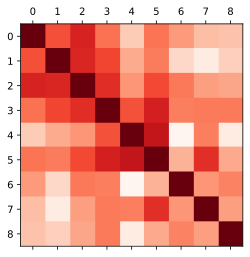

In [11]:
from sklearn import metrics
from matplotlib import pyplot as plt
sims = metrics.pairwise.cosine_similarity(doc_vectors)
print(sims)
_ = plt.matshow(sims, cmap='Reds')

We display the least and the most similar documents:

In [12]:
# set the diagonal (self-similarity) to NaN so it can be ignored
np.fill_diagonal(sims, np.nan)   
imin = np.unravel_index(np.nanargmin(sims),sims.shape)
imax = np.unravel_index(np.nanargmax(sims),sims.shape)
print('Least similar:\n{}\n{}\n'.format(raw_docs[imin[0]], raw_docs[imin[1]]))
print('Most similar:\n{}\n{}'.format(raw_docs[imax[0]], raw_docs[imax[1]]))

Least similar:
Interactions between functionalised silica nanoparticles and Pseudomonas fluorescens biofilm matrix
How schools can reopen safely during the pandemic

Most similar:
Interactions between functionalised silica nanoparticles and Pseudomonas fluorescens biofilm matrix
A multi-parametric screening platform for photosynthetic trait characterization of microalgae and cyanobacteria under inorganic carbon limitation
